In [11]:
import os
import cv2
import imagehash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
#import pytesseract
from scipy.stats import entropy

In [253]:
DATASET_FOLDER = "test_task_logo_dataset"

In [254]:
files = next(os.walk(DATASET_FOLDER))[2]
files = list(filter(lambda x: x.endswith("jpg"), files))
files = list(map(lambda x: os.path.join(DATASET_FOLDER, x), files))
files = np.array(files)

In [255]:
df = pd.DataFrame([])
df["path"] = files
df["hash"] = df["path"].apply(lambda x: str(imagehash.phash(Image.open(x))))

In [58]:
def compute_groups(series, threshold=50):
    
    series = series.apply(lambda x: 2 * imagehash.hex_to_hash(x).hash.astype(np.int8) - 1)
    series = np.array(series.tolist())
    matrix = np.einsum("kij,mij->km", series, series)
    
    groups = map(lambda x: list(np.where(x > threshold)[0]), list(matrix))
        
    return groups

def compute_entropy(img):

    r, _ = np.histogram(img[..., 0], bins=255)
    g, _ = np.histogram(img[..., 1], bins=255)
    b, _ = np.histogram(img[..., 2], bins=255)

    return entropy(r), entropy(g), entropy(b)

In [264]:
groups = compute_groups(df.hash)

In [269]:
df["group"] = -1
with tqdm(ascii=True, leave=False, total=len(df)) as bar:
    for i, group in enumerate(groups):
        if (df["group"].loc[group] == -1).any():
            df.loc[group, "group"] = i
        bar.update()

In [271]:
df.to_csv("dataset_full.csv", index=False)

In [296]:
counts = df.groupby("group").count().reset_index()[["group", "path"]]
counts = counts.rename(columns={"path": "n_images"})

In [297]:
clean = df.groupby("group").apply(lambda g: g["path"].iloc[0]).reset_index()

In [298]:
clean = pd.DataFrame(clean)
clean = clean.rename(columns={0: "path"})

In [300]:
clean = clean.merge(counts, how="inner", on="group")

In [308]:
clean.to_csv("dataset.csv", index=False)

In [309]:
clean

,group,path,n_images
0,0,test_task_logo_dataset/a7ee2ad0-f27a-4189-9207...,1
1,1,test_task_logo_dataset/a3ff6c0b-1aa2-4fb2-be20...,1
2,2,test_task_logo_dataset/e2524a86-a652-4181-90c4...,1
3,3,test_task_logo_dataset/f0b3e6ef-f025-471c-942e...,2
4,4,test_task_logo_dataset/42b000e9-4346-486b-b3d6...,1
...,...,...,...
32153,36240,test_task_logo_dataset/4809662e-1d0e-4a25-a721...,1
32154,36241,test_task_logo_dataset/64108cf4-9d72-4003-a8f9...,1
32155,36242,test_task_logo_dataset/e5110399-79a9-4864-8227...,1
32156,36243,test_task_logo_dataset/2c955ab4-89ad-41fd-8422...,1


In [59]:
df["entropy_r"] = 0
df["entropy_g"] = 0
df["entropy_b"] = 0
df["h"] = 0
df["w"] = 0

with tqdm(ascii=True, leave=False, total=len(df)) as bar:

    for index, row in df.iterrows():
        
        img = np.array(Image.open(row.path))
        r, g, b = compute_entropy(img)
        df.loc[index, "entropy_r"] = r
        df.loc[index, "entropy_g"] = g
        df.loc[index, "entropy_b"] = b
        df.loc[index, "h"] = img.shape[0]
        df.loc[index, "w"] = img.shape[1]

        bar.update()
            
df["entropy"] = (df["entropy_r"] + df["entropy_g"] + df["entropy_b"]) / 3.0
df = df.sort_values(by="entropy")

In [54]:
def display_images(csv, rows, cols, show=True, title_column=None, fname=None):
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8), dpi=150)
    n_total = len(csv)
    
    n_grid = rows * cols
    subset = csv.sample(n=n_grid, replace=n_grid > n_total)
    
    axes = axes.ravel() if n_grid > 1 else [axes]
    
    i = 0
    
    for index, row in subset.iterrows():
        image = cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(image)
        if title_column:
            title = row[title_column]
            if title != "no_logo":
                title = "logo"
            #title = "\n".join(title.split())
            axes[i].set_title(title, fontsize=10)
        axes[i].set_axis_off()
        axes[i].imshow(image)
        axes[i].set_axis_off()
        
        i += 1
        
    if fname is not None:
        plt.savefig(fname, dpi=150)
    if show:
        #plt.tight_layout()
        plt.show()
    plt.close(fig)

In [46]:
df = pd.read_csv("dataset_with_labels.csv")

In [116]:
df[df.n_images > 1]

,group,path,n_images,api_score,api_name,entropy_r,entropy_g,entropy_b,h,w,entropy
13753,14804,test_task_logo_dataset/7955e285-be50-4b71-983f...,2,-1.0,-1,1.078368,1.078368,1.078368,76,79,1.078368
21323,23437,test_task_logo_dataset/19406b01-d76b-4e14-9d8e...,3,-1.0,-1,1.193574,1.112969,1.040699,46,51,1.115747
3468,3619,test_task_logo_dataset/a24d4d84-bbec-41a1-9335...,2,-1.0,-1,1.150568,1.150568,1.150568,75,184,1.150568
13707,14754,test_task_logo_dataset/636d7728-19c7-4cc4-8aa8...,2,-1.0,-1,1.258647,1.135170,1.098397,58,63,1.164071
3695,3868,test_task_logo_dataset/0e2cb64c-46c8-44a6-bc06...,2,-1.0,-1,1.239073,1.236264,1.272675,53,62,1.249337
...,...,...,...,...,...,...,...,...,...,...,...
14811,15974,test_task_logo_dataset/c60c1b34-d5d2-4d5c-9ebd...,2,-1.0,-1,5.358010,5.380928,5.349696,157,125,5.362878
6650,7024,test_task_logo_dataset/feb51c74-2610-45e0-8361...,2,-1.0,-1,5.359464,5.364062,5.372822,98,372,5.365449
296,306,test_task_logo_dataset/1d04e491-47eb-4cc0-814a...,2,-1.0,-1,5.375689,5.416304,5.408853,60,143,5.400282
2307,2404,test_task_logo_dataset/50dc774e-6ded-4cf9-a1a7...,10,-1.0,-1,5.399066,5.422001,5.397852,67,111,5.406306


In [66]:
df

,group,path,n_images,api_score,api_name,entropy_r,entropy_g,entropy_b,h,w,entropy
2797,2915,test_task_logo_dataset/feed596f-0893-47c6-8156...,1,-1.0,-1,0.000000,0.000000,0.000000,3,24,0.000000
21729,23907,test_task_logo_dataset/2f6dee24-4418-438c-b8e2...,1,-1.0,-1,0.989610,0.956135,0.958199,50,353,0.967981
8707,9259,test_task_logo_dataset/7b49f2ff-dcd1-49e4-8edb...,1,-1.0,-1,1.043702,0.981002,0.933905,47,56,0.986203
30505,34268,test_task_logo_dataset/30230c74-6a4e-4a41-bd01...,1,-1.0,-1,1.064124,0.856394,1.064124,62,188,0.994881
3099,3235,test_task_logo_dataset/9497ea6a-3e33-4455-8cfb...,1,-1.0,-1,0.993385,1.003255,1.012575,441,269,1.003072
...,...,...,...,...,...,...,...,...,...,...,...
12088,12960,test_task_logo_dataset/b48faaad-48a5-479b-a38a...,1,-1.0,-1,5.388961,5.464780,5.526125,607,1151,5.459955
25945,28866,test_task_logo_dataset/22f31592-ee02-461c-b01f...,1,-1.0,-1,5.468097,5.468962,5.467702,58,122,5.468254
24922,27669,test_task_logo_dataset/2deca010-08b8-4f9d-bddf...,1,-1.0,-1,5.446546,5.473996,5.490587,80,90,5.470376
19858,21724,test_task_logo_dataset/8d7fa911-3b16-419e-b82e...,1,-1.0,-1,5.468868,5.472851,5.477188,77,53,5.472969


In [62]:
df[df.api_name == "no_logo"]

,group,path,n_images,api_score,api_name,entropy_r,entropy_g,entropy_b,h,w,entropy
31274,35184,test_task_logo_dataset/5e21fd1f-2144-468d-9d2d...,1,0.0,no_logo,1.426101,1.426101,1.426101,72,94,1.426101
32064,36137,test_task_logo_dataset/ab9629d1-aee8-4a02-8a69...,1,0.0,no_logo,1.141947,1.663584,1.831160,81,278,1.545563
31254,35160,test_task_logo_dataset/edfafe2e-4cc0-477a-86a2...,1,0.0,no_logo,1.921661,1.921661,1.921661,52,85,1.921661
32065,36138,test_task_logo_dataset/c45038e4-277f-41e1-91e4...,1,0.0,no_logo,2.104799,2.104799,2.104799,72,253,2.104799
31889,35929,test_task_logo_dataset/8d5be6e8-3c65-41e9-b3bb...,1,0.0,no_logo,2.122187,2.122187,2.122187,128,171,2.122187
...,...,...,...,...,...,...,...,...,...,...,...
31750,35756,test_task_logo_dataset/f557fc00-e8b6-4896-a00a...,1,0.0,no_logo,5.320313,5.309594,5.304101,99,178,5.311336
31295,35212,test_task_logo_dataset/4a4dcdd3-b908-4d04-927b...,1,0.0,no_logo,5.302986,5.399277,5.318430,76,157,5.340231
31809,35832,test_task_logo_dataset/a9568464-b6b3-49ec-aa6e...,1,0.0,no_logo,5.384101,5.332002,5.313449,488,485,5.343184
32018,36087,test_task_logo_dataset/17161895-874f-4a89-b7c3...,1,0.0,no_logo,5.335588,5.433655,5.353313,38,224,5.374186


In [106]:
counts = df.groupby(["h", "w"]).count().sort_values(by="group")

In [107]:
counts = counts[counts.group > 25]

In [108]:
counts

,,group,path,n_images,api_score,api_name,entropy_r,entropy_g,entropy_b,entropy
h,w,,,,,,,,,
42,41,26,26,26,26,26,26,26,26,26
37,37,26,26,26,26,26,26,26,26,26
39,40,26,26,26,26,26,26,26,26,26
56,55,26,26,26,26,26,26,26,26,26
43,43,27,27,27,27,27,27,27,27,27
40,40,27,27,27,27,27,27,27,27,27
49,50,27,27,27,27,27,27,27,27,27
39,38,28,28,28,28,28,28,28,28,28
41,42,29,29,29,29,29,29,29,29,29


In [122]:
df[df.n_images > 3]

,group,path,n_images,api_score,api_name,entropy_r,entropy_g,entropy_b,h,w,entropy
6062,6394,test_task_logo_dataset/dc845dcb-b056-48ca-b808...,4,-1.0,-1,1.874680,1.874680,1.874680,59,62,1.874680
3192,3332,test_task_logo_dataset/71b433d0-9718-4d07-9934...,6,-1.0,-1,1.928661,1.928661,1.928661,61,64,1.928661
5297,5569,test_task_logo_dataset/02248f25-07cb-4a9a-805a...,4,-1.0,-1,2.038345,2.038345,1.986002,40,141,2.020897
4827,5069,test_task_logo_dataset/1bba2ec5-5a60-478d-a6ab...,7,-1.0,-1,2.080436,2.080436,2.080436,107,90,2.080436
9580,10208,test_task_logo_dataset/fb7bd1bb-f79f-407b-aab8...,8,-1.0,-1,1.560321,2.688744,2.544790,54,55,2.264618
...,...,...,...,...,...,...,...,...,...,...,...
2233,2326,test_task_logo_dataset/43f39e81-69d9-4e36-bfce...,28,-1.0,-1,5.197271,5.253243,5.280933,73,72,5.243815
3426,3575,test_task_logo_dataset/c8f9ca5a-5c90-46f3-9f2a...,4,-1.0,-1,5.374898,5.187999,5.199588,48,141,5.254162
11460,12279,test_task_logo_dataset/25eba2e0-d2c9-4a7f-9f53...,6,-1.0,-1,5.261329,5.264432,5.320019,67,75,5.281927
5449,5732,test_task_logo_dataset/e1752325-6bdb-4ee8-976b...,27,-1.0,-1,5.418681,5.272497,5.176303,76,105,5.289160


<AxesSubplot:>

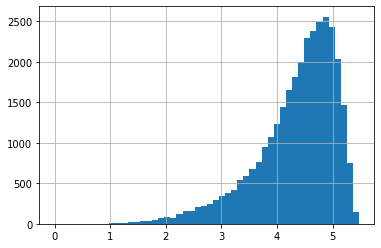

In [68]:
df.entropy.hist(bins=50)

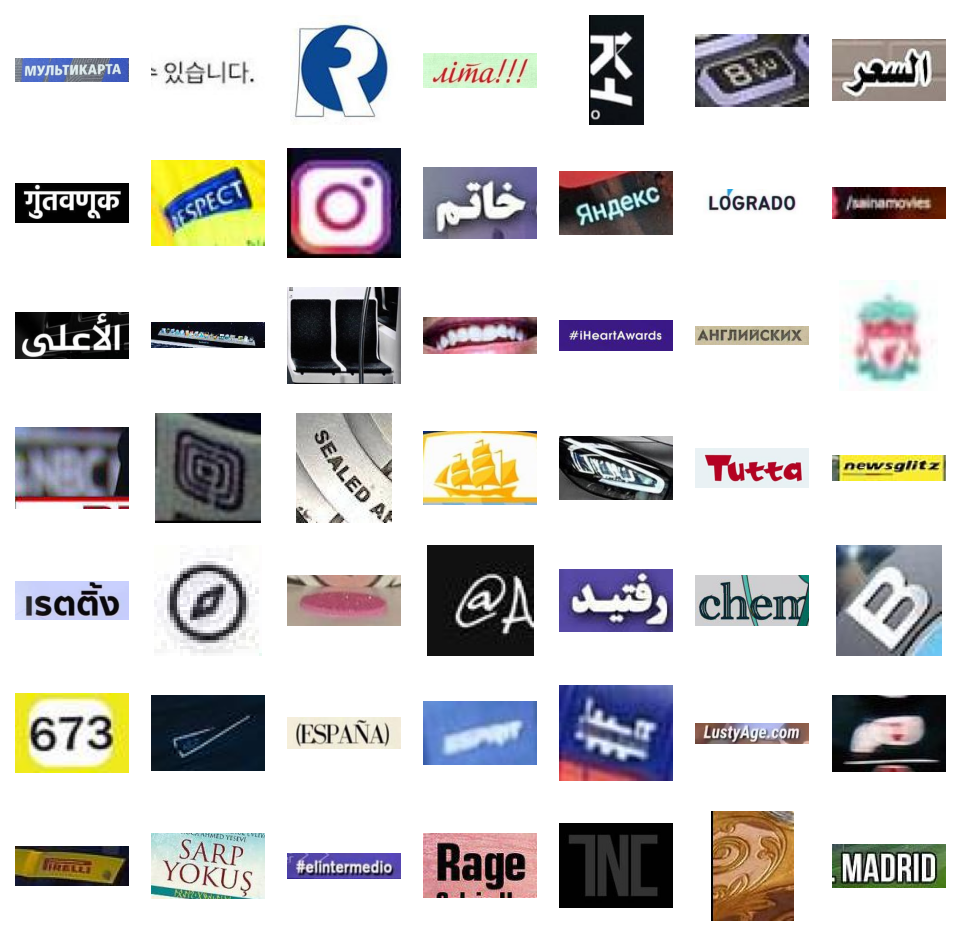

In [65]:
display_images(df[df.api_name == "no_logo"], 7, 7)

In [53]:
(16 / 36 + 14 / 32 + 11 / 36) / 3

0.3958333333333333

In [39]:
100 - 19.4

80.6